In [1]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import pickle
import os
import numpy as np

from collections import OrderedDict

In [2]:
import matplotlib
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [3]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['figure.dpi'] = 600

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams["svg.fonttype"] = 'none'
mpl.rcParams['font.size'] = '6'

In [4]:
# matplotlib inline
%matplotlib auto

Using matplotlib backend: <object object at 0x7f56a262d7f0>


In [5]:
linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
     
colors = ['#3682be','#45a776','#f05326','#eed777','#334f65','#b3974e','#38cb7d','#ddae33','#844bb3','#93c555','#5f6694','#df3881']
     
linestyles = linestyles_dict.keys()

### 1. Perturbation study

In [6]:
method_list = ['random', 'attn_last', 'rollout_2', 'gi', 'lrp_detach_KQ_LNorm_Norm', "ig"]

#### Test in single modality

In [7]:
all_labels = []
res_dict = {"random":[], "attn_last":[], "rollout_2":[], "gi":[], "lrp_detach_KQ":[], "lrp_detach_KQ_LNorm_Norm":[], "ig":[]}

for fold_i in range(0,5):
    pickle_file = os.path.join('../exp_explain_multimodal/vital_explain', f'fold_{fold_i}_all_flips_pruning_sst.p')
    pickle_file_ig = os.path.join('../exp_explain_multimodal/vital_explain', f'fold_{fold_i}_all_flips_pruning_ig.p')
    

    with open(pickle_file, "rb") as f:
        all_flips = pickle.load(f)
    print(pickle_file)
    
    with open(pickle_file_ig, "rb") as f:
        all_flips_ig = pickle.load(f)
    print(pickle_file_ig)
    
    for i in all_flips['random']['Evolution']:
        all_labels.append(int(i['y_true']))
    
    for k, v in all_flips.items():
        res_dict[k].append(np.array(v['E'])[:, :, 1])
    for k, v in all_flips_ig.items():
        res_dict[k].append(np.array(v['E'])[:, :, 1])

../exp_explain_multimodal/vital_explain/fold_0_all_flips_pruning_sst.p
../exp_explain_multimodal/vital_explain/fold_0_all_flips_pruning_ig.p
../exp_explain_multimodal/vital_explain/fold_1_all_flips_pruning_sst.p
../exp_explain_multimodal/vital_explain/fold_1_all_flips_pruning_ig.p
../exp_explain_multimodal/vital_explain/fold_2_all_flips_pruning_sst.p
../exp_explain_multimodal/vital_explain/fold_2_all_flips_pruning_ig.p
../exp_explain_multimodal/vital_explain/fold_3_all_flips_pruning_sst.p
../exp_explain_multimodal/vital_explain/fold_3_all_flips_pruning_ig.p
../exp_explain_multimodal/vital_explain/fold_4_all_flips_pruning_sst.p
../exp_explain_multimodal/vital_explain/fold_4_all_flips_pruning_ig.p


In [25]:
pickle.dump(all_labels, open('ts_explain/vital_pruning_labels_new.p', 'wb'))
pickle.dump(res_dict, open('ts_explain/vital_pruning_res_new.p', 'wb'))

In [26]:
res_dict.keys()

dict_keys(['random', 'attn_last', 'rollout_2', 'gi', 'lrp_detach_KQ', 'lrp_detach_KQ_LNorm_Norm', 'ig'])

In [27]:
method_list

['random', 'attn_last', 'rollout_2', 'gi', 'lrp_detach_KQ_LNorm_Norm', 'ig']

In [28]:
f, axs = plt.subplots(1, figsize=(4*3, 3*2))

fracs = np.linspace(0, 1., 11)
for k in method_list:
    v= res_dict[k]
    auc_list = []

    for i in range(len(fracs)):
        auc_list.append(roc_auc_score(all_labels[:], np.concatenate(v, axis=0)[:, i][:]))

    axs.plot(fracs, auc_list, label=k)
    #axs.legend()
    score = np.trapz(y=auc_list, x=fracs, dx=0.1)
    print(k, score)
    axs.set_title('Time series events')  
    axs.set_xlabel("% nodes pruning")
    axs.set_ylabel("AUC-ROC")
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    
    axs.legend()

print(auc_list)

random 0.6925925017246908
attn_last 0.695727892379296
rollout_2 0.697332583538191
gi 0.7077574647531506
lrp_detach_KQ_LNorm_Norm 0.7078964845457991
ig 0.7030560548791743
[0.7265063109107339, 0.724514900356598, 0.7235913405948482, 0.722197498955469, 0.7198582352769707, 0.7168135487820282, 0.7127491085049117, 0.7089032910014865, 0.7017907634307258, 0.6868651437566194, 0.5000471253534401]


#### Plot perturbation

In [6]:
method_list = ['random', 'attn_last', 'rollout_2', 'gi', 'lrp_detach_KQ_LNorm_Norm', "ig"]

In [7]:
f, axs = plt.subplots(1,3, figsize=(2.5*3, 1.5*1))

all_labels = pickle.load(open('ts_explain/ts_pruning_labels_new.p', 'rb'))
res_dict = pickle.load(open('ts_explain/ts_pruning_res_new.p', 'rb'))

fracs = np.linspace(0, 1., 11)

for k in method_list:
    v= res_dict[k]
    auc_list = []

    for i in range(len(fracs)):
        auc_list.append(roc_auc_score(all_labels[:], np.concatenate(v, axis=0)[:, i][:]))

    axs[0].plot(fracs, auc_list, label=k)
    # axs[1,0].legend()
    score = np.trapz(y=auc_list, x=fracs, dx=0.1)
    print(k, score)
    # axs[1,0].set_title('ROC-AUC')  
    axs[0].set_xlabel("% nodes removed")
    axs[0].set_ylabel("AUC-ROC")
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

print(auc_list)

random 0.7447314462139394
attn_last 0.7701796229000069
rollout_2 0.7724448220410624
gi 0.7673633000378947
lrp_detach_KQ_LNorm_Norm 0.7767429943546741
ig 0.7744734713409835
[0.8283575599755143, 0.8210266525452549, 0.8194112731618682, 0.8145374427937075, 0.8087274211257616, 0.8015242865610153, 0.7963757202405821, 0.7851742180592127, 0.7431840706588805, 0.6906419736292352, 0.4999057492931197]


In [8]:
all_labels = pickle.load(open('vital_explain/vital_pruning_labels_new.p', 'rb'))
res_dict = pickle.load(open('vital_explain/vital_pruning_res_new.p', 'rb'))

# f, axs = plt.subplots(3, figsize=(4, 3))
fracs = np.linspace(0, 1., 11)

for k in method_list:
    v= res_dict[k]
    auc_list = []

    for i in range(len(fracs)):
        auc_list.append(roc_auc_score(all_labels[:], np.concatenate(v, axis=0)[:, i][:]))

    axs[1].plot(fracs, auc_list, label=k)
    #axs.legend()
    score = np.trapz(y=auc_list, x=fracs, dx=0.1)
    print(k, score)
    #axs.set_title('ROC-AUC')  
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xlabel("% nodes removed")
    axs[1].set_ylabel("AUC-ROC")
# plt.legend()
print(auc_list)

random 0.6925925017246908
attn_last 0.695727892379296
rollout_2 0.697332583538191
gi 0.7077574647531506
lrp_detach_KQ_LNorm_Norm 0.7078964845457991
ig 0.7030560548791743
[0.7265063109107339, 0.724514900356598, 0.7235913405948482, 0.722197498955469, 0.7198582352769707, 0.7168135487820282, 0.7127491085049117, 0.7089032910014865, 0.7017907634307258, 0.6868651437566194, 0.5000471253534401]


In [9]:
all_labels = pickle.load(open('note_explain/note_pruning_labels_new.p', 'rb'))
res_dict = pickle.load(open('note_explain/note_pruning_res_new.p', 'rb'))

# f, axs = plt.subplots(2,3, figsize=(4*3, 3*2))

fracs = np.linspace(0, 1., 11)

method_name = {"random":"Random", "attn_last":"Attention last", "rollout_2":"Attention Rollout", "gi":"LRP","lrp_detach_KQ_LNorm_Norm":"LRPTrans","ig":"IG"}

for k in method_list:
    v= res_dict[k]
    auc_list = []
    
    for i in range(len(fracs)):
        auc_list.append(roc_auc_score(all_labels[:], np.concatenate(v, axis=0)[:, i][:]))

# method_list = ['random', ""attn_last""]
    
    axs[2].plot(fracs, auc_list, label=method_name[k])
    #axs[2].legend()
    score = np.trapz(y=auc_list, x=fracs, dx=0.1)
    print(k, score)
    #axs.set_title('ROC-AUC')  
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].set_xlabel("% nodes removed")
    axs[2].set_ylabel("AUC-ROC")
    axs[2].legend(ncol=3, bbox_to_anchor=(0.2,-0.3))


random 0.7047041548043569
attn_last 0.7306789451694083
rollout_2 0.7119123419843175
gi 0.7436401906390587
lrp_detach_KQ_LNorm_Norm 0.7547530291399867
ig 0.7545865357521109


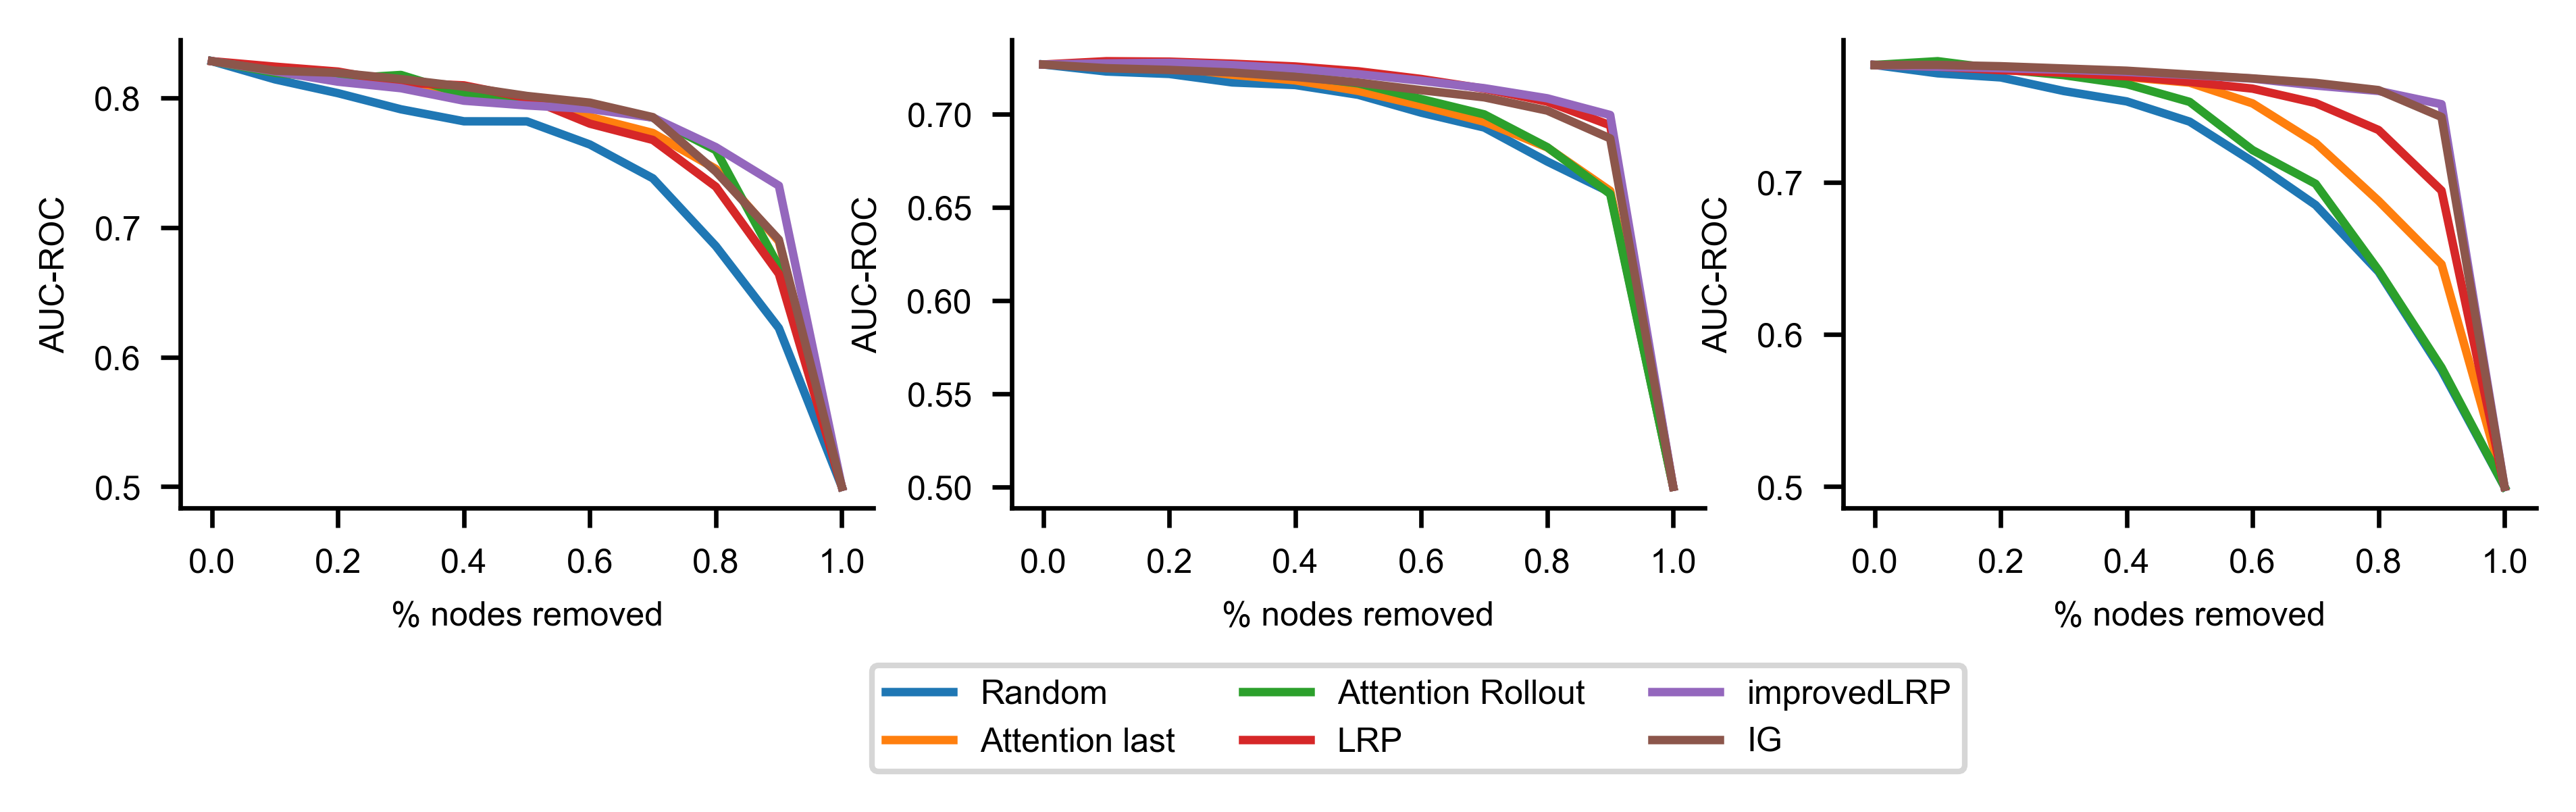

In [10]:
%matplotlib inline
plt.savefig('../draw/fig3_perturbation.svg', format='svg', dpi=600, bbox_inches="tight")
plt.show()

### 2. Explanation

In [11]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import pickle
import os
import numpy as np
import pandas as pd

from collections import OrderedDict
import plotly.express as px

import plotly.io as pio

In [12]:
def softmax(x):
    '''Compute softmax values for each sets of scores in x.'''
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 

In [13]:
def logsoftmax(x):
    return x - np.log(np.sum(np.exp(x), axis=0))

#### Single case results

In [14]:
pickle_file = os.path.join('../exp_explain_multimodal/multimodal_explain/', 'fold_0.p')
    

with open(pickle_file, "rb") as f:
    result = pickle.load(f)
print(pickle_file)

../exp_explain_multimodal/multimodal_explain/fold_0.p


In [15]:
sample_index = 4

In [16]:
attr_list = result[sample_index][0]

In [17]:
logits = attr_list[0]
physi_attr = attr_list[1]['R']
notes_attr = attr_list[2]['R']
vital_attr = attr_list[3]['R']
print(f"logits: {logits}\n"
      f"physi attr {sum(physi_attr.reshape(-1))}\n"
      f"notes attr {sum(notes_attr.reshape(-1))}\n"
      f"vital attr {sum(vital_attr.reshape(-1))}\n"
      f"sum attr {sum([sum(physi_attr.reshape(-1)), sum(notes_attr.reshape(-1)), sum(vital_attr.reshape(-1))])}\n"
      f"softmax {softmax([sum(physi_attr.reshape(-1)), sum(notes_attr.reshape(-1)), sum(vital_attr.reshape(-1))])}")

logits: [[-0.43519717  0.27228284]]
physi attr 0.09643262345343828
notes attr 0.03081822078638652
vital attr -0.034145758242061675
sum attr 0.09310508599776313
softmax [0.35535597 0.33278799 0.31185603]


#### Conservation analysis

In [18]:
all_logits = []
all_attr = []
for each_pickle_file in os.listdir('../exp_explain_multimodal/multimodal_explain/'):
    pickle_file = os.path.join('../exp_explain_multimodal/multimodal_explain/', each_pickle_file)
    with open(pickle_file, "rb") as f:
        result = pickle.load(f)
        for each_case in result:
            attr_list = each_case[0]
            logits = attr_list[0][0][1]
            physi_attr = attr_list[1]['R']
            notes_attr = attr_list[2]['R']
            vital_attr = attr_list[3]['R']
            all_attr.append(sum([sum(physi_attr.reshape(-1)), sum(notes_attr.reshape(-1)), sum(vital_attr.reshape(-1))]))
            all_logits.append(logits)

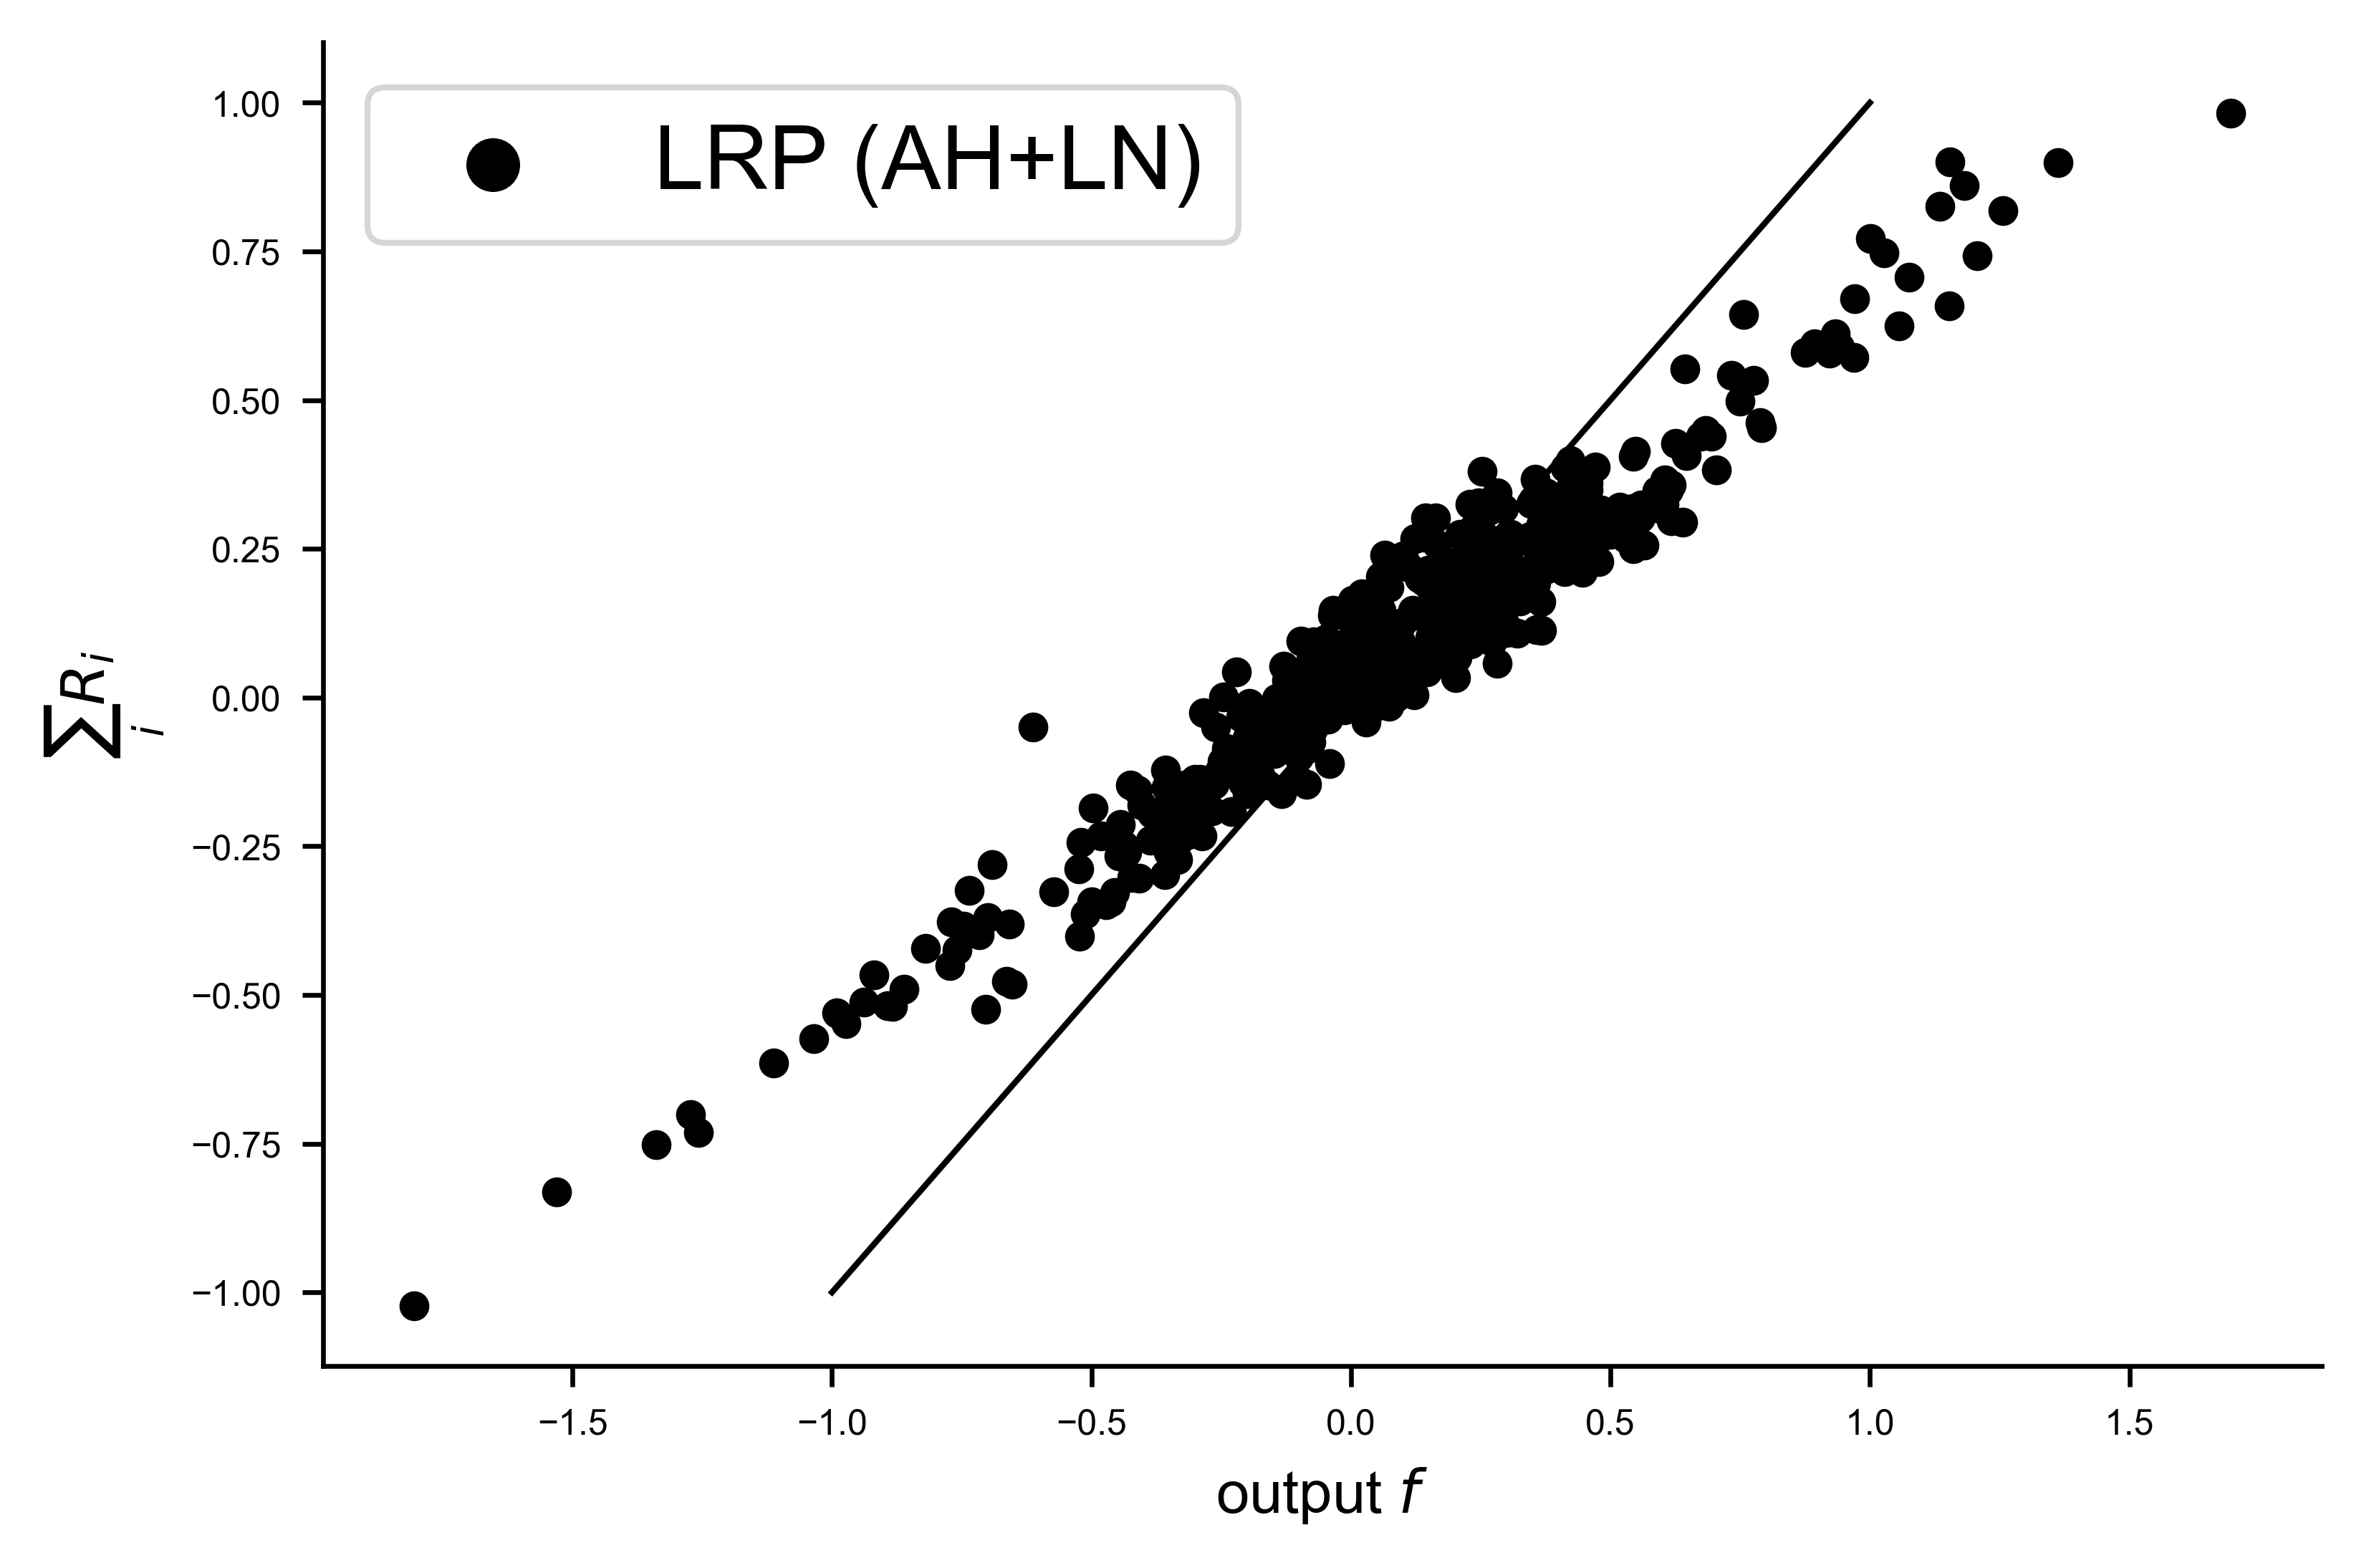

In [21]:
f, ax = plt.subplots(1,1, figsize=(6, 4))

plt.scatter(all_logits, all_attr, label=r'LRP (AH+LN)', s=16, color='black')
plt.plot([-1,1],[-1,1],color='black', linestyle='-', linewidth=1)

ax.set_ylabel('$\sum_i R_i$', fontsize=10)
ax.set_xlabel('output $f$', fontsize=10)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(fontsize=15,  markerscale=2)

#f.tight_layout()

#### Salient features in time series

In [16]:
variable_attr = []

for each_pickle_file in os.listdir('../exp_explain_multimodal/multimodal_explain/'):
    pickle_file = os.path.join('../exp_explain_multimodal/multimodal_explain/', each_pickle_file)
    with open(pickle_file, "rb") as f:
        result = pickle.load(f)
        for each_case in result:
            attr_list = each_case[0]
            ts_attr = attr_list[1]['all_R']
            variable_attr.append(ts_attr.mean(axis=0))

In [17]:
import pandas as pd
import sys

root_dir = '../'
sys.path.append(root_dir)

from utils import MultiModalReader, MultiModalDataset, PhysiDiscretizer, PhysiNormalizer, read_chunk


data_df = pd.read_csv("data/dataset.csv")
reader = MultiModalReader(dataset_dir='.', listfile_df=data_df, period_length=24.0, modal=['physi'])

In [18]:
reader.read_example(0)['physi']
discretizer = PhysiDiscretizer(timestep=1.0,
                               store_masks=True,
                               impute_strategy='previous',
                               start_time='zero')
discretizer_header = discretizer.transform(reader.read_example(0)["physi"])[1].split(',')
feature_name = discretizer_header

In [19]:
mean_variable_attr = np.array(variable_attr).mean(0)

In [20]:
feature_without_mask = []
variable_without_mask = []
for feature, variable in zip(feature_name, mean_variable_attr):
    if "mask" in feature:
        continue
    # if "->" in feature:
    #     continue
    feature_without_mask.append(feature)
    variable_without_mask.append(variable)

In [21]:
feature_name_filter = []
variable_filter = []
for i, m in zip(feature_without_mask,variable_without_mask):
    if i == "Glascow coma scale eye opening->None":
        feature_name_filter.append("GCS eye opening->1")
    elif i == "Glascow coma scale verbal response->Confused":
        feature_name_filter.append("GCS verbal response->4")
        
    elif i == "Glascow coma scale motor response->Flex-withdraws":
        continue
        # feature_name_filter.append("GCS motor response->4")
    elif i == "Glascow coma scale verbal response->1 No Response":
        feature_name_filter.append("GCS verbal response->1")
    elif i == "Glascow coma scale verbal response->1.0 ET/Trach":
        feature_name_filter.append("GCS verbal response->1")
    elif i == "Glascow coma scale motor response->Abnormal Flexion":
        feature_name_filter.append("GCS motor response->3")
    elif i == "Glascow coma scale motor response->4 Flex-withdraws":
        feature_name_filter.append("GCS motor response->4")
    elif i == "Glascow coma scale eye opening->2 To pain":
        feature_name_filter.append("GCS eye opening->2")
    elif i == "Glascow coma scale motor response->Localizes Pain":
        feature_name_filter.append("GCS motor response->5")
    else:
        feature_name_filter.append(i)
    variable_filter.append(m)

In [22]:
len(variable_filter)

58

/tmp/ipykernel_355501/1624280312.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  map_vir = cm.get_cmap(name='inferno')


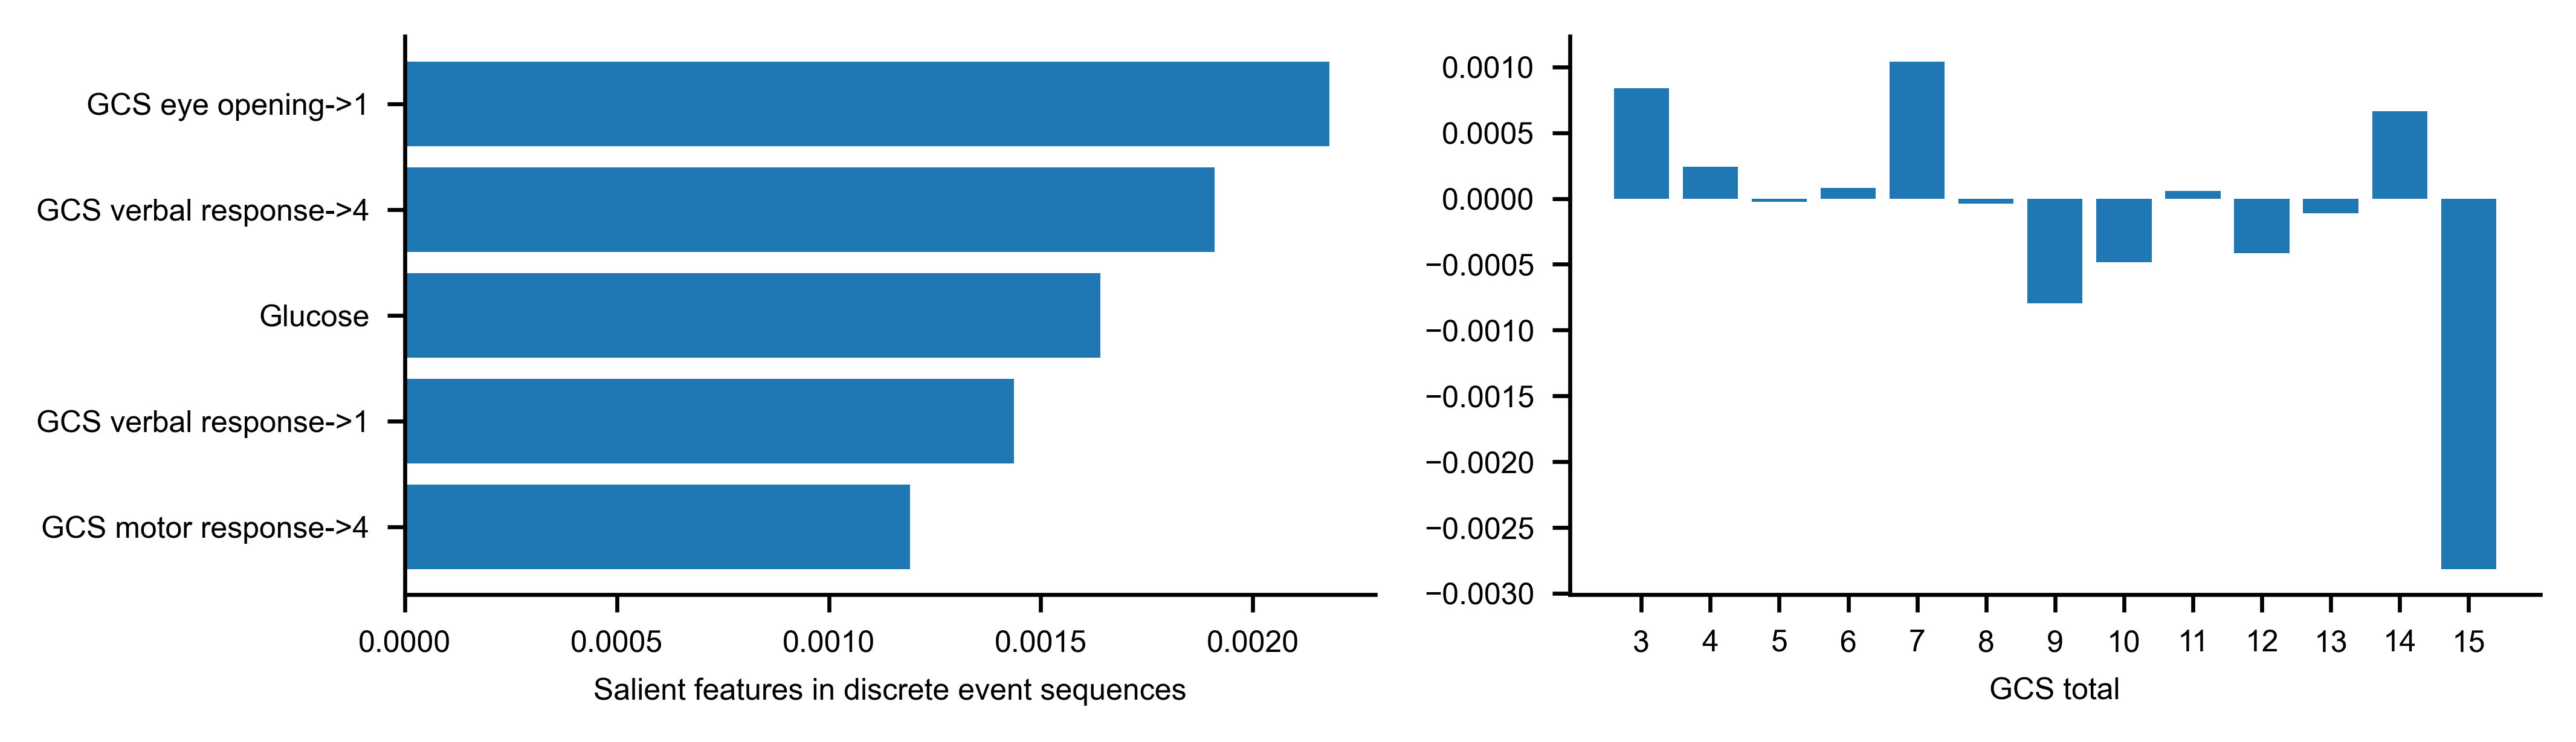

In [24]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['figure.dpi'] = 600

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams["svg.fonttype"] = 'none'
mpl.rcParams['font.size'] = '6'

sort_index = np.argsort(variable_filter).astype(np.int16)

fig, ax = plt.subplots(1, 2, figsize=(7.6, 2))

ax[0].barh(np.array([i.replace("Glascow coma scale", "GCS") for i in feature_name_filter])[sort_index][-5:], np.array(variable_filter)[sort_index][-5:])

#ax[0].yaxis.set_tick_params(labelleft='on')

ax[0].xaxis.set_tick_params(labelbottom='off')

ax[0].spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)

gcs_total_feature = []
gcs_attr = []
for feature, variable in zip(feature_name_filter, variable_filter):
    if "total" in feature:
        gcs_total_feature.append(feature)
        gcs_attr.append(variable)

ax[0].set_xlabel("Salient features in discrete event sequences")


from matplotlib import cm

map_vir = cm.get_cmap(name='inferno')


new_sort_index = np.argsort([float(i.split('->')[1]) for i in gcs_total_feature]).astype(np.int16)

colors = map_vir(np.array(gcs_attr)[new_sort_index])

ax[1].bar(np.array([i.replace("Glascow coma scale total->", "").replace(".0","") for i in gcs_total_feature])[new_sort_index], np.array(gcs_attr)[new_sort_index])


#ax[1].yaxis.set_tick_params(labelleft='on')

ax[1].xaxis.set_tick_params(labelbottom='off')

# ax[1].xaxis.set_tick_params(labelbottom='off')

# ax[1].set_xticks([])

ax[1].spines['top'].set_visible(False)

ax[1].spines['right'].set_visible(False)

ax[1].set_xlabel("GCS total")

# ax[1].spines['bottom'].set_visible(False)

plt.savefig('../draw/fig4_modality_events.svg', format='svg', dpi=600)

#### Salient tokens in notes

In [56]:
token_attr = {}
token_cnt = {}
for each_pickle_file in os.listdir('../exp_explain_multimodal/multimodal_explain/'):
    pickle_file = os.path.join('../exp_explain_multimodal/multimodal_explain/', each_pickle_file)
    with open(pickle_file, "rb") as f:
        result = pickle.load(f)
        for each_case in result:
            attr_list = each_case[0]
            
            notes_input = each_case[1].flatten()
            notes_attr = attr_list[2]['R'].flatten()
            
            for k,v in zip(notes_input, notes_attr):  
                k = int(k.detach().cpu().numpy())
                if k not in token_attr:
                    token_attr[k] = v
                    token_cnt[k] = 1
                else:
                    token_attr[k] += v
                    token_cnt[k] += 1

In [57]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f77f0654d50>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json
Could not locate the tokenizer configuration file, will try to use the model config instead.
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f77f0524a10>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/config.json
loading configuration file config.json from cache at /home/li

In [81]:
new_dict = {}
for k,v in token_attr.items():
    if token_cnt[k] <= 150:
        continue
    token = tokenizer.convert_ids_to_tokens(k)
    new_dict[token] = v / token_cnt[k]

In [82]:
len(new_dict)

258

In [83]:
token_list = []
attr_list = []
for k, v in new_dict.items():
    if "#" in k:
        continue
    if len(k) <= 3:
        continue
    if "[" in k:
        continue
    token_list.append(k)
    attr_list.append(v)

In [84]:
sort_index = np.argsort(np.array(attr_list)).astype(np.int16)

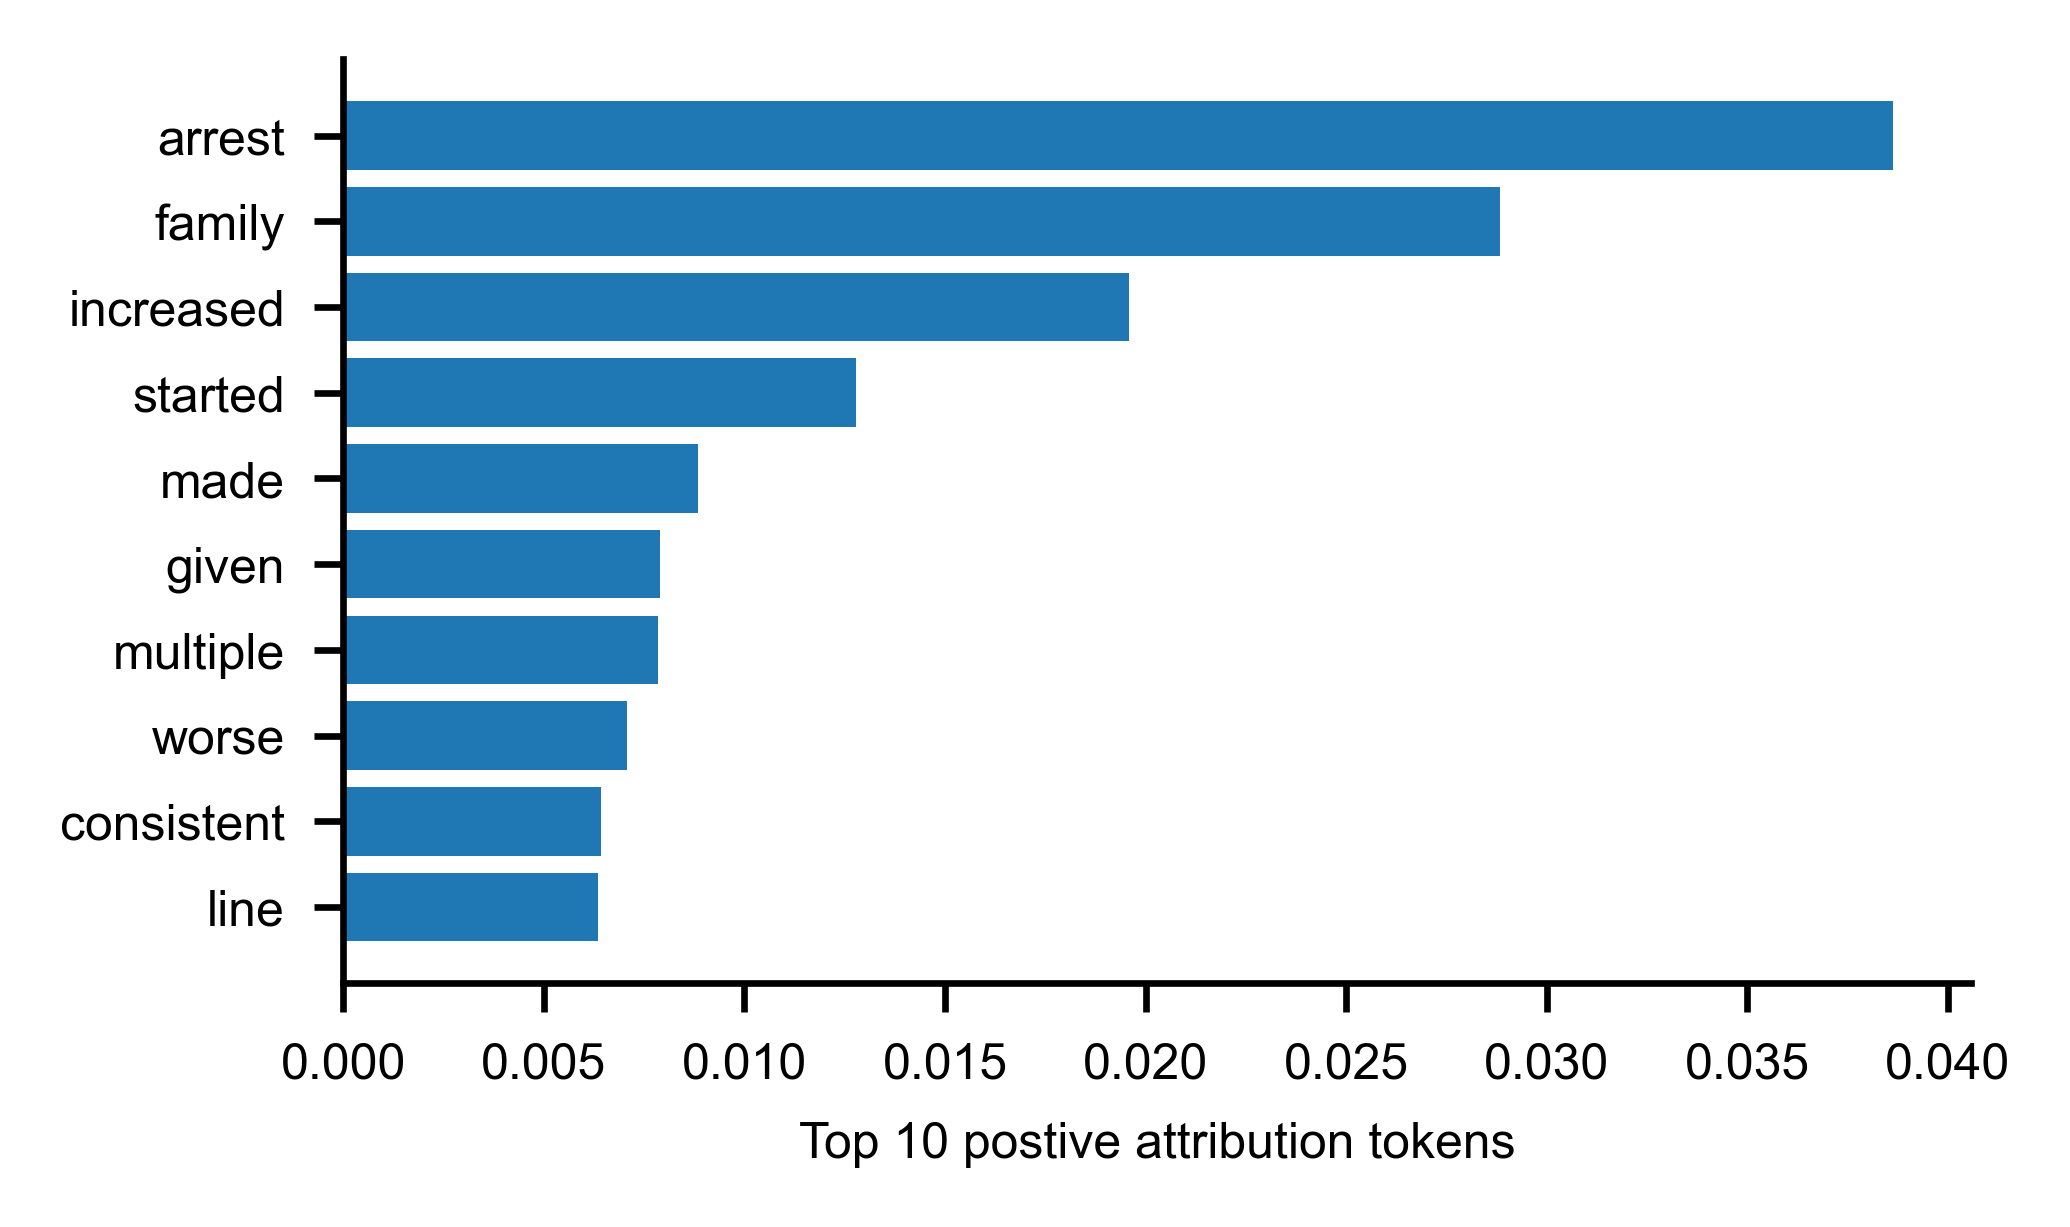

In [77]:
# cut off 100

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.barh(np.array(token_list)[sort_index][-10:], np.array(np.abs(attr_list))[sort_index][-10:])

# plt.xticks(rotation=90)

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

ax.set_xlabel("Top 10 postive attribution tokens")

plt.savefig('../draw/fig4_notes_positive.svg', format='svg', dpi=600)

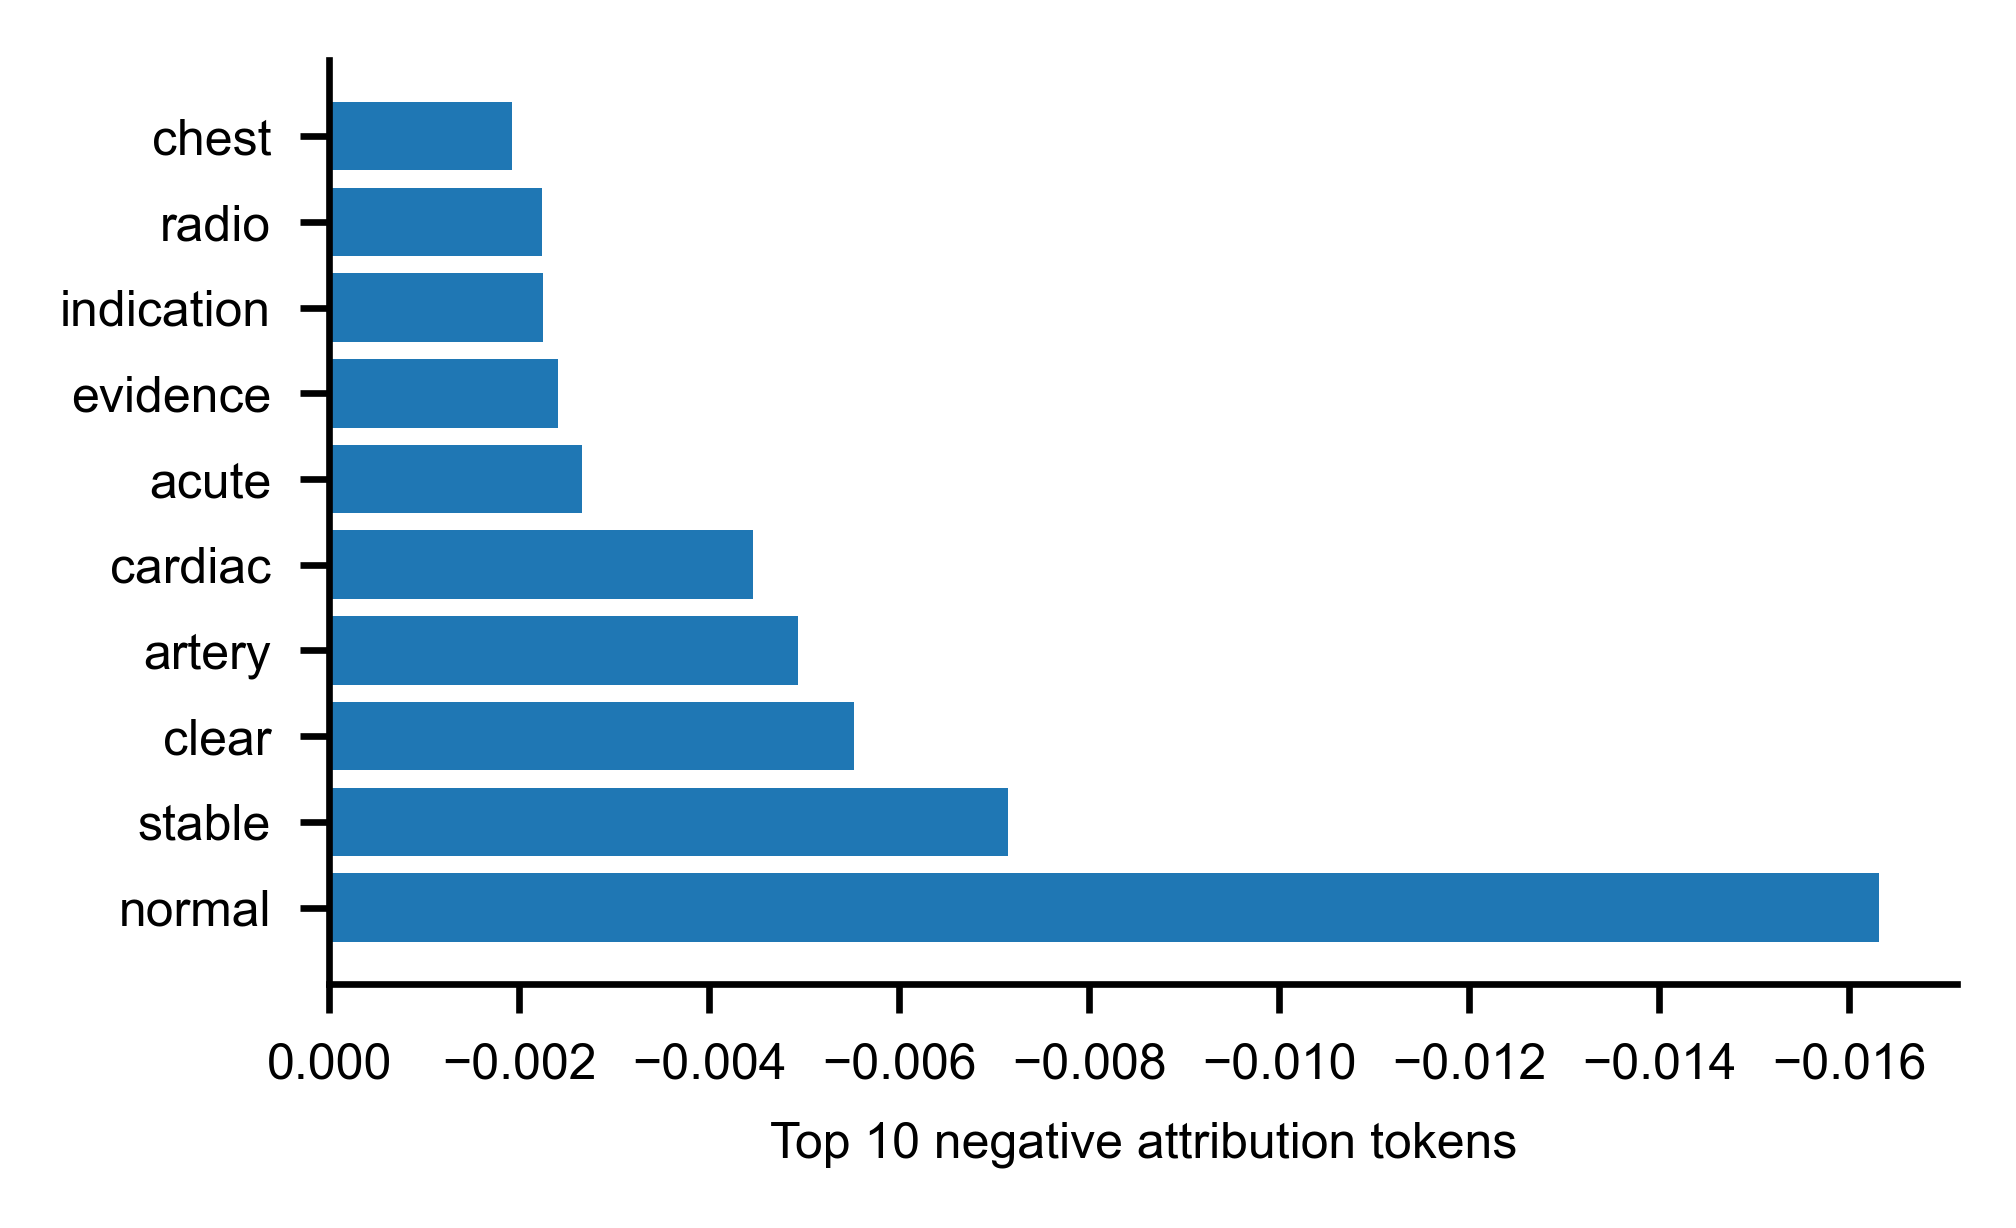

In [85]:
# cut off 150

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.barh(np.array(token_list)[sort_index][:10:], np.array(attr_list)[sort_index][:10])

# plt.xticks(rotation=90)

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

plt.gca().invert_xaxis()

ax.set_xlabel("Top 10 negative attribution tokens")

plt.savefig('../draw/fig4_notes_negative.svg', format='svg', dpi=600)

#### Salient vital signs

In [87]:
variable_attr = []

for each_pickle_file in os.listdir('../exp_explain_multimodal/multimodal_explain/'):
    pickle_file = os.path.join('../exp_explain_multimodal/multimodal_explain/', each_pickle_file)
    with open(pickle_file, "rb") as f:
        result = pickle.load(f)
        for each_case in result:
            attr_list = each_case[0]
            
            vital_attr = attr_list[3]['all_R']
            
            variable_attr.append(vital_attr.mean(axis=0))

In [88]:
import pandas as pd
import sys

root_dir = '../'
sys.path.append(root_dir)

from utils import MultiModalReader, MultiModalDataset, VitalDiscretizer, VitalNormalizer, read_chunk


data_df = pd.read_csv("data/dataset.csv")
reader = MultiModalReader(dataset_dir='.', listfile_df=data_df, period_length=24.0, modal=['vital'])

In [89]:
reader.read_example(0)['vital']
discretizer = VitalDiscretizer(timestep=0.05,
                               store_masks=False,
                               impute_strategy='previous',
                               start_time='zero')
discretizer_header = discretizer.transform(reader.read_example(0)["vital"])[1].split(',')

In [90]:
discretizer_header

['ABP_dias',
 'ABP_mean',
 'ABP_sys',
 'All_beat_count',
 'Atrial_paced_beat_count',
 'Bigeminy_percent',
 'CVP',
 'HR',
 'NBP_dias',
 'NBP_mean',
 'NBP_sys',
 'Normal_beat_count',
 'PAP_dias',
 'PAP_mean',
 'PAP_sys',
 'PULSE',
 'PVC_count',
 'RESP',
 'SpO2',
 'Vent_paced_percent',
 'pNN50_percent']

In [91]:
sort_index = np.argsort(np.array(variable_attr).mean(0)).astype(np.int16)

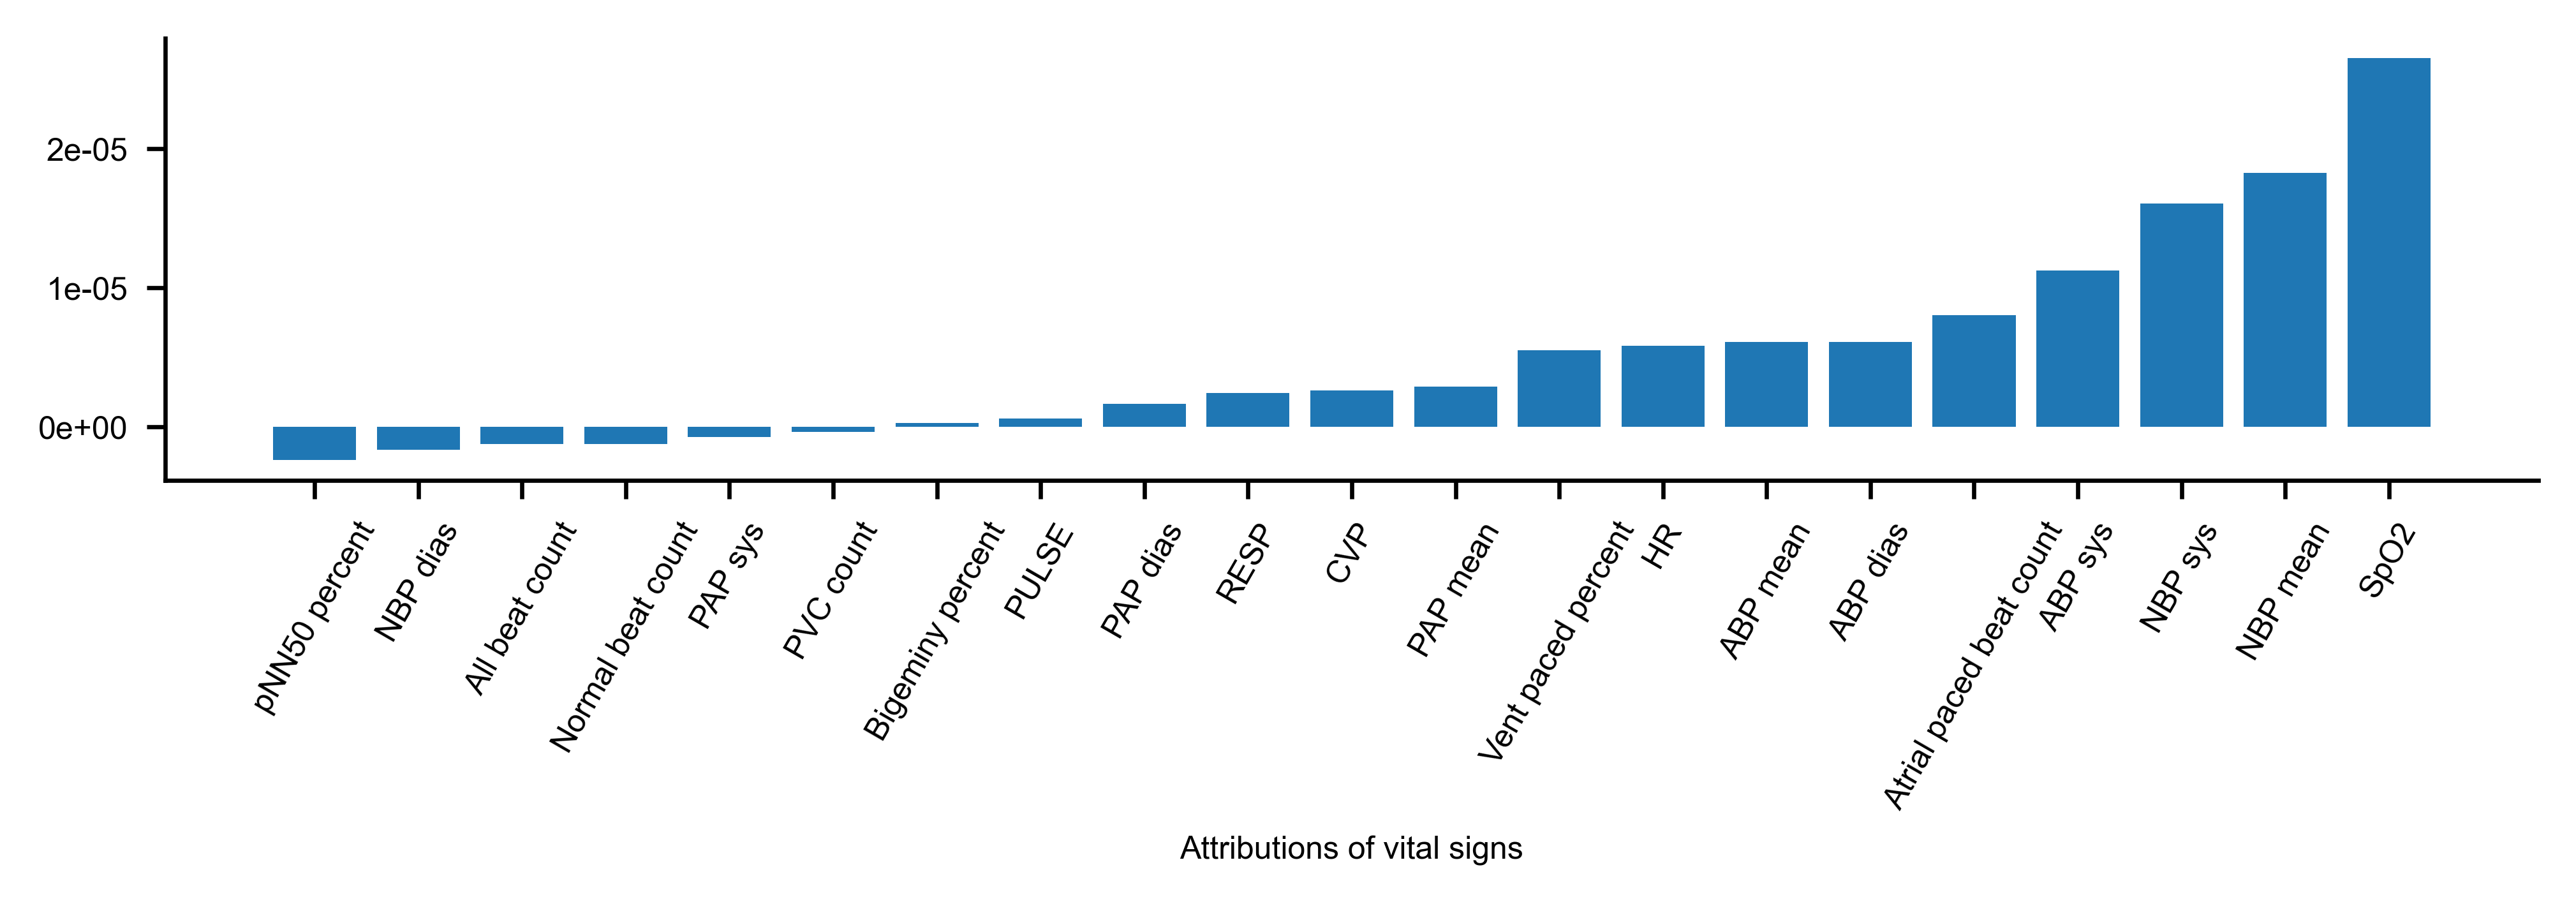

In [92]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(8, 1.5))

feature_name = discretizer_header

ax.bar([i.replace("_"," ") for i in np.array(feature_name)[sort_index]], np.array(variable_attr).mean(0)[sort_index])

plt.xticks(rotation=60)


ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

ax.set_xlabel('Attributions of vital signs')

plt.savefig('../draw/fig4_vitalsigns.svg', format='svg', dpi=600)

### 3. Case study

In [93]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['figure.dpi'] = 600

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams["svg.fonttype"] = 'none'
mpl.rcParams['font.size'] = '6'

In [94]:
import pandas as pd

total_physi = []
total_vital = []
total_notes = []
all_results = []
for each_pickle_file in os.listdir('../exp_explain_multimodal/multimodal_explain/'):
    pickle_file = os.path.join('../exp_explain_multimodal/multimodal_explain/', each_pickle_file)
    print(pickle_file)
    with open(pickle_file, "rb") as f:
        result = pickle.load(f)
        for each_case in result:
            attr_list = each_case[0]
            physi_attr = attr_list[1]['R']
            notes_attr = attr_list[2]['R']
            vital_attr = attr_list[3]['R']

            total_physi.append(sum(physi_attr.reshape(-1)))
            total_notes.append(sum(notes_attr.reshape(-1)))
            total_vital.append(sum(vital_attr.reshape(-1)))
            
            all_results.append(each_case)

../exp_explain_multimodal/multimodal_explain/fold_4.p
../exp_explain_multimodal/multimodal_explain/fold_0.p
../exp_explain_multimodal/multimodal_explain/fold_3.p
../exp_explain_multimodal/multimodal_explain/fold_1.p
../exp_explain_multimodal/multimodal_explain/fold_2.p


In [95]:
df = pd.DataFrame({"Time events": total_physi, "Notes": total_notes, "Vital signs": total_vital})

df['Type'] = df.idxmax(axis=1)

In [96]:
df

,Time events,Notes,Vital signs,Type
0,0.099858,-0.164611,0.026196,Time events
1,0.060113,0.247356,0.036883,Notes
2,-0.119260,0.073424,-0.003924,Notes
3,0.082333,0.106457,0.049266,Notes
4,-0.001173,0.077156,0.018878,Notes
...,...,...,...,...
480,0.120072,0.148929,0.014367,Notes
481,0.141628,0.029390,-0.061202,Time events
482,0.108752,0.180377,0.028647,Notes
483,0.054242,0.131611,0.056413,Notes


In [97]:
df.loc[df['Type'] == 'Notes'].sort_values(by='Notes')

,Time events,Notes,Vital signs,Type
111,-0.125817,-0.048410,-0.055552,Notes
183,-0.264001,-0.013762,-0.025094,Notes
157,-0.059389,0.006581,-0.058520,Notes
269,-0.091625,0.008366,-0.016958,Notes
140,-0.208820,0.008446,-0.034474,Notes
...,...,...,...,...
266,0.110740,0.277127,0.164918,Notes
281,0.289187,0.301420,0.068111,Notes
113,0.061955,0.304604,-0.019268,Notes
253,0.313216,0.324289,0.262792,Notes


In [98]:
sample_index = 281

In [99]:
attr_list = all_results[sample_index][0]
notes_input = all_results[sample_index][1]
physi_input = all_results[sample_index][2]
vital_input = all_results[sample_index][3]
output = attr_list[0]

In [100]:
print(output)

[[-1.6983759  1.1530197]]


#### notes visulization

In [101]:
notes_attr = attr_list[2]['R']

In [102]:
from captum.attr import visualization
from transformers import AutoTokenizer

In [103]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f77b834f610>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json
Could not locate the tokenizer configuration file, will try to use the model config instead.
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f77f0268dd0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/config.json
loading configuration file config.json from cache at /home/li

In [104]:
all_tokens = tokenizer.convert_ids_to_tokens(notes_input.flatten())

In [105]:
label = 1

In [106]:
expl = notes_attr.flatten()

In [107]:
expl = (expl - expl.mean()) / expl.std()

In [108]:
tokenizer.decode(notes_input.detach().cpu().numpy().flatten())

'[CLS]tol and dilantin, emotional support for husband, social work consulted. aneurysm, other assessment : pt is unresponsive, does not open eyes to name, and does not follow commands when propofol stopped for neuro exam. pt postures both upper ext and triple flexes both lower ext. perl 3 - 2mm brisk. + gag, + cough. tmax action : family meeting this afternoon with neuro team to discuss pt prognosis. social worker spoke with family prior to meeting and was present for meeting. blood cultures x2 and urine culture obtained for temp of 5 response : awaiting family to make decision whether to proceed with surgery versus comfort measures. plan : continue to monitor neuro assessment every two hours. continue to offer pt and pt family emotional support throughout hospitalization. social worker available to support family as well. awaiting results of blood and urine cultures. addendum : 1600 neuro assessment : left pupil 6 - 7mm and non - reactive, right pupil 3mm and non reactive, gag and cou

In [109]:
def remove_speciel_words(attr, tokens):
    out_words = []
    out_attrs = []
    flag = 0
    for _attr, _tokens in zip(attr, tokens):
        if flag == 1:
            out_words[-1] += _tokens
            out_attrs[-1] += _attr
            if _tokens.endswith('##'):
                flag = 1
            else:
                flag = 0
        
        if _tokens.endswith('##'):
            out_attrs.append(_attr)
            out_words.append(_tokens)
            flag = 1
            
        else:
            if not _tokens.startswith("##"):
                out_attrs.append(_attr)
                out_words.append(_tokens)
            else:
                out_words[-1] += _tokens
                out_attrs[-1] += _attr
    out_words = [each_tokens.replace('##', '')for each_tokens in out_words]
    return out_attrs, out_words

In [110]:
out_attrs, out_words = remove_speciel_words(expl, all_tokens)

In [111]:
vis_data_records = [visualization.VisualizationDataRecord(
                                out_attrs, # "word_attributions",
                                output[0][1], # "pred_prob",
                                1, # preds class
                                1, # "true_class",
                                1, # "attr_class",
                                expl.sum(), #  "attr_score",     
                                out_words, # tokens
                                0)]
visualization.visualize_text(vis_data_records)

#### Time events visulization

In [112]:
import pandas as pd
import sys

root_dir = '../'
sys.path.append(root_dir)

from utils import MultiModalReader, MultiModalDataset, PhysiDiscretizer, PhysiNormalizer, read_chunk


data_df = pd.read_csv("data/dataset.csv")
reader = MultiModalReader(dataset_dir='.', listfile_df=data_df, period_length=24.0, modal=['physi'])

In [113]:
reader.read_example(0)['physi']
discretizer = PhysiDiscretizer(timestep=1.0,
                               store_masks=True,
                               impute_strategy='previous',
                               start_time='zero')
discretizer_header = discretizer.transform(reader.read_example(0)["physi"])[1].split(',')
feature_name = discretizer_header

In [114]:
cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]
normalizer = PhysiNormalizer(fields=cont_channels)
normalizer.load_params('../utils/ihm_ts1.0.input_str:previous.start_time:zero.normalizer')

In [115]:
cont_channels

[2, 3, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]

In [116]:
normalizer._means.shape

(76,)

In [117]:
normalizer._stds.shape

(76,)

In [118]:
df = pd.DataFrame({"Time events": total_physi, "Notes": total_notes, "Vital signs": total_vital})

df['Type'] = df.idxmax(axis=1)

In [119]:
df.loc[df['Type'] == 'Time events'].sort_values(by='Time events').index.values

array([450,  37, 341, 333,  32, 154, 449, 472, 390, 327,  13,  89,  17,
       397, 325, 121,  92, 473, 439,  38, 418, 123,  24, 132, 181, 425,
       324,  23, 169, 294,  30, 155, 466,  58, 452,  43,  64, 410, 311,
       464,  95, 415, 106, 438, 109,  39, 177, 139, 467,  15, 291, 101,
        35,  90,  68, 427,  83, 276, 173,   0, 456, 143,  28, 342, 461,
        56, 455, 424, 145, 344,  44, 446, 191, 409, 443, 103, 422, 186,
       484,  48, 299, 135, 349, 412, 376, 405, 339, 395, 474,  47, 433,
       185, 393,  65, 475, 453, 150, 414, 251, 431, 383, 303,  54, 459,
       454, 363, 400, 320, 441, 335, 460, 304, 481, 351, 322, 375, 129,
       417, 411, 429, 199, 408, 458, 270, 479, 323, 352, 353, 345, 297,
       329, 359, 354, 350, 315, 318, 379, 336, 343, 310, 338, 382, 361,
       295, 355, 337, 217, 386, 374, 347, 313, 331, 319, 227, 300, 283,
       370, 369, 378, 326, 377, 277, 372, 358, 292, 371, 301, 436, 357,
       285, 365, 255, 332, 284, 381, 334, 262, 197, 298, 384, 28

In [120]:
sample_index = 264

In [121]:
attr_list = all_results[sample_index][0]
notes_input = all_results[sample_index][1]
physi_input = all_results[sample_index][2]
vital_input = all_results[sample_index][3]
output = attr_list[0]

In [122]:
output

array([[-2.5058296,  1.6951036]], dtype=float32)

In [123]:
attr = attr_list[1]['all_R']

In [124]:
physi_attr = attr_list[1]['R']
notes_attr = attr_list[2]['R']
vital_attr = attr_list[3]['R']

print(sum(physi_attr.reshape(-1)))
print(sum(notes_attr.reshape(-1)))
print(sum(vital_attr.reshape(-1)))

0.36771008669165894
0.34445981043973006
0.27068608267290983


In [125]:
data = physi_input.squeeze().detach().cpu().numpy()

In [126]:
no_mask_index = []
for index, each_feature in enumerate(feature_name):
    if "mask" not in each_feature:
        no_mask_index.append(index)

attr = attr[:, no_mask_index]
feature_name = np.array(feature_name)[no_mask_index]
data = data[:, no_mask_index]

In [127]:
sort_index = np.argsort(attr.mean(0))
best_three_index = sort_index[-5:]

In [128]:
best_three_index

array([54, 39, 56, 18, 30])

In [129]:
# shape is length, channels 
best_three_attr = attr[:,best_three_index]

In [130]:
best_three_featurenames = np.array(feature_name)[best_three_index]

In [131]:
print(best_three_featurenames)

['Respiratory rate' 'Glascow coma scale verbal response->Confused'
 'Temperature' 'Glascow coma scale motor response->Flex-withdraws'
 'Glascow coma scale total->3.0']


In [132]:
best_three_data_li = []
for each_index in best_three_index:
    if each_index in cont_channels:
        best_three_data_li.append(data[:,each_index] * normalizer._stds[each_index] + normalizer._means[each_index])
    else:
        best_three_data_li.append(data[:,each_index])
best_three_data = np.stack(best_three_data_li)

In [133]:
# shape is length, channels 
# best_three_data = data[:,best_three_index]

In [134]:
from captum.attr import visualization

In [135]:
attr = np.transpose(best_three_attr)
data = best_three_data

num_channels = attr.shape[0]
timeseries_length = attr.shape[1]

num_subplots = num_channels

print(num_channels, num_subplots)

5 5


In [136]:
def _normalize_scale(attr, scale_factor):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)


def _cumulative_sum_threshold(values, percentile):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]


def _normalize_attr(
    attr,
    outlier_perc = 2,
    reduction_axis = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    # Choose appropriate signed values and rescale, removing given outlier percentage.
    threshold = _cumulative_sum_threshold(np.abs(attr_combined), 100 - outlier_perc)
    return _normalize_scale(attr_combined, threshold)

norm_attr = _normalize_attr(attr)

In [137]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib import cm, colors
from matplotlib.figure import Figure
from matplotlib.pyplot import axis, figure

cmap = LinearSegmentedColormap.from_list(
    "RdWhGn", ["red", "white", "green"]
)
vmin, vmax = -1, 1

cmap = cm.get_cmap(cmap)

cm_norm = colors.Normalize(vmin, vmax)

/tmp/ipykernel_354422/827755601.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


In [138]:
def _plot_attrs_as_axvspan(attr_vals, x_vals, ax):

    half_col_width = (x_values[1] - x_values[0]) / 2.0
    for icol, col_center in enumerate(x_vals):
        left = col_center - half_col_width
        right = col_center + half_col_width
        ax.axvspan(
            xmin=left,
            xmax=right,
            facecolor=(cmap(cm_norm(attr_vals[icol]))),
            edgecolor=None,
            alpha=0.7,
        )

In [139]:
x_values = np.arange(timeseries_length)

In [140]:
data

array([[13.      , 16.      , 21.      , 21.      , 21.      , 21.      ,
        21.      , 21.      , 26.      , 48.      , 29.      , 32.      ,
        24.      , 24.      , 21.      , 23.      , 24.      , 24.      ,
        24.      , 24.      , 24.      , 24.      , 24.      , 24.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [36.600002, 35.5556  , 35.5556  , 35.5556  , 35.5556  , 35.5556  ,
        35.5556  , 35.5556  , 35.6667  , 35.6667  , 35.6667  , 35.6667  ,
        31.111113, 31.111113, 31.111113, 31.111113, 31.111113, 31.111113,
        31.111113, 31.111113, 31.111113, 31.111113, 31.111113, 31.111113],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.  

In [145]:
feature_name

array(['Capillary refill rate->0.0', 'Capillary refill rate->1.0',
       'Diastolic blood pressure', 'Fraction inspired oxygen',
       'Glascow coma scale eye opening->To Pain',
       'Glascow coma scale eye opening->3 To speech',
       'Glascow coma scale eye opening->1 No Response',
       'Glascow coma scale eye opening->4 Spontaneously',
       'Glascow coma scale eye opening->None',
       'Glascow coma scale eye opening->To Speech',
       'Glascow coma scale eye opening->Spontaneously',
       'Glascow coma scale eye opening->2 To pain',
       'Glascow coma scale motor response->1 No Response',
       'Glascow coma scale motor response->3 Abnorm flexion',
       'Glascow coma scale motor response->Abnormal extension',
       'Glascow coma scale motor response->No response',
       'Glascow coma scale motor response->4 Flex-withdraws',
       'Glascow coma scale motor response->Localizes Pain',
       'Glascow coma scale motor response->Flex-withdraws',
       'Glascow coma 

In [146]:
meta_df = pd.read_csv('../data/dataset/multimodal.csv')

In [147]:
all_df = []
for i in [4,0,3,1,2]:
    fold_df = meta_df.loc[~meta_df[f'fold_{i}']]
    died_case = fold_df.loc[fold_df['mortality'] == 1]
    all_df.append(died_case)

In [148]:
deadcase_df = pd.concat(all_df, ignore_index=True)

In [149]:
deadcase_df.iloc[sample_index]

mortality                                                                                                                  1
los                                                                                                                     24.6
Acute and unspecified renal failure                                                                                        1
Acute cerebrovascular disease                                                                                              0
Acute myocardial infarction                                                                                                0
Cardiac dysrhythmias                                                                                                       0
Chronic kidney disease                                                                                                     0
Chronic obstructive pulmonary disease and bronchiectasis                                                                   0


In [150]:
test_df = pd.read_csv('../data/' + deadcase_df.iloc[sample_index]['physi'])

In [151]:
test_df

,Hours,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH
0,0.233333,NaN,41.0,NaN,NaN,NaN,NaN,NaN,NaN,84.0,NaN,50.0,NaN,12.0,59.0,NaN,NaN,NaN
1,0.483333,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN,48.0,NaN,12.0,62.0,NaN,NaN,NaN
2,0.733333,NaN,40.0,NaN,1 No Response,1 No Response,3.0,1.0 ET/Trach,NaN,90.0,NaN,47.0,NaN,13.0,58.0,NaN,NaN,7.23
3,1.483333,NaN,54.0,NaN,NaN,NaN,NaN,NaN,NaN,93.0,NaN,65.0,NaN,16.0,83.0,NaN,NaN,NaN
4,1.533333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,NaN,NaN,NaN,NaN,7.22
5,1.733333,NaN,52.0,NaN,NaN,NaN,NaN,NaN,NaN,89.0,NaN,63.0,NaN,16.0,79.0,35.555599,NaN,NaN
6,2.450000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN
7,2.733333,NaN,53.0,NaN,NaN,NaN,NaN,NaN,NaN,91.0,NaN,65.0,NaN,21.0,81.0,NaN,NaN,NaN
8,3.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0,NaN,NaN,NaN,NaN,7.25
9,3.233333,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,92.0,NaN,51.0,NaN,21.0,64.0,NaN,NaN,NaN


In [152]:
draw_df = test_df.dropna(subset=["Hours", "Glascow coma scale motor response"])

In [153]:
draw_df = draw_df.loc[draw_df['Glascow coma scale motor response'] == '4 Flex-withdraws']

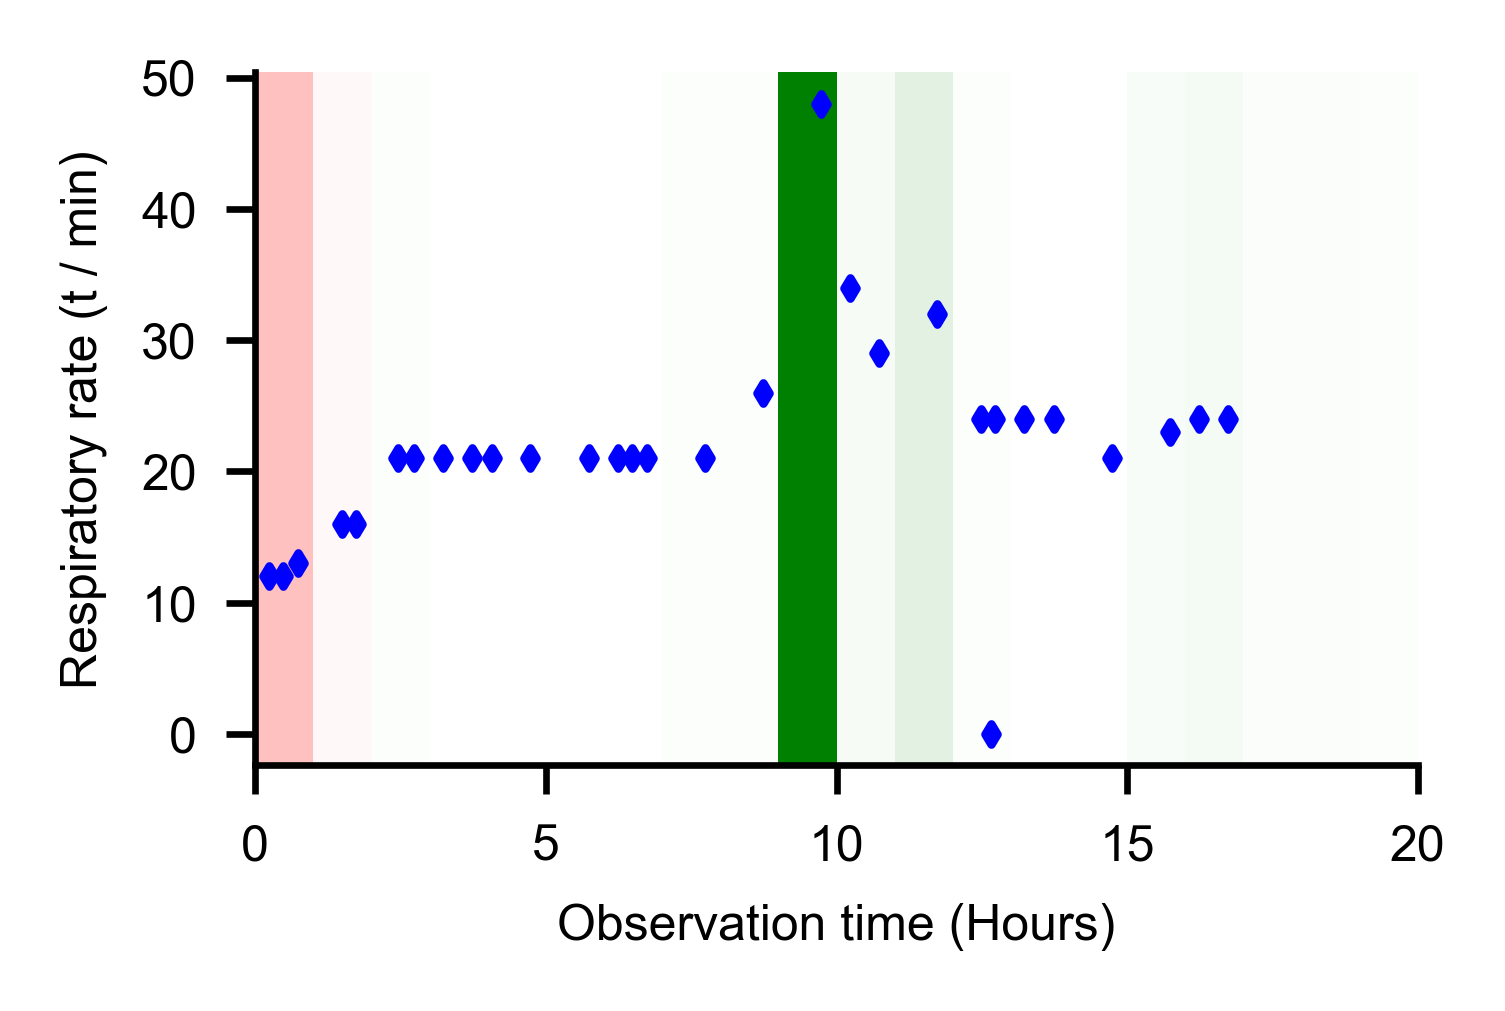

In [154]:
plt_fig, plt_axis=plt.subplots(1, figsize=(2.5,1.5))

x_values = np.arange(timeseries_length)

half_col_width = (x_values[1] - x_values[0]) / 2.0


for icol, col_center in enumerate(x_values):
    left = col_center
    right = col_center + 2 * half_col_width
    plt_axis.axvspan(
        xmin=left,
        xmax=right,
        facecolor=(cmap(cm_norm(norm_attr[0][icol]))),
        edgecolor=None,
        alpha=1,
    )

plt_axis.scatter(test_df['Hours'], test_df['Respiratory rate'], s=3, marker='d', alpha=1, c="b")




plt_axis.set_xlim(0,20)

plt_axis.set_ylabel("Respiratory rate (t / min)")

plt_axis.set_xlabel("Observation time (Hours)")

plt_axis.spines['top'].set_visible(False)

plt_axis.spines['right'].set_visible(False)

# plt_axis.spines['left'].set_visible(False)

# plt_axis.spines['bottom'].set_visible(False)

plt.savefig('../draw/fig5_case_events.svg', format='svg', dpi=600)

#### Vital signs

In [155]:
from utils import MultiModalReader, MultiModalDataset, VitalDiscretizer, VitalNormalizer, read_chunk

In [156]:
data_df = pd.read_csv("data/dataset.csv")
reader = MultiModalReader(dataset_dir='.', listfile_df=data_df, period_length=24.0, modal=['vital'])

In [157]:
reader.read_example(0)['vital']
discretizer = VitalDiscretizer(timestep=0.05,
                               store_masks=False,
                               impute_strategy='previous',
                               start_time='zero')
discretizer_header = discretizer.transform(reader.read_example(0)["vital"])[1].split(',')
feature_name = discretizer_header

In [158]:
feature_name

['ABP_dias',
 'ABP_mean',
 'ABP_sys',
 'All_beat_count',
 'Atrial_paced_beat_count',
 'Bigeminy_percent',
 'CVP',
 'HR',
 'NBP_dias',
 'NBP_mean',
 'NBP_sys',
 'Normal_beat_count',
 'PAP_dias',
 'PAP_mean',
 'PAP_sys',
 'PULSE',
 'PVC_count',
 'RESP',
 'SpO2',
 'Vent_paced_percent',
 'pNN50_percent']

In [159]:
cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]
normalizer = PhysiNormalizer(fields=cont_channels)
normalizer.load_params("../utils/vital_mask_0.05_False.normalizer")

In [160]:
df = pd.DataFrame({"Time events": total_physi, "Notes": total_notes, "Vital signs": total_vital})

df['Type'] = df.idxmax(axis=1)

In [161]:
df

,Time events,Notes,Vital signs,Type
0,0.099858,-0.164611,0.026196,Time events
1,0.060113,0.247356,0.036883,Notes
2,-0.119260,0.073424,-0.003924,Notes
3,0.082333,0.106457,0.049266,Notes
4,-0.001173,0.077156,0.018878,Notes
...,...,...,...,...
480,0.120072,0.148929,0.014367,Notes
481,0.141628,0.029390,-0.061202,Time events
482,0.108752,0.180377,0.028647,Notes
483,0.054242,0.131611,0.056413,Notes


In [162]:
df.loc[df['Type'] == 'Vital signs'].sort_values(by='Vital signs')

,Time events,Notes,Vital signs,Type
401,-0.059151,-0.365115,-0.057194,Vital signs
249,-0.081737,-0.228593,-0.032800,Vital signs
279,-0.246304,-0.454025,-0.030872,Vital signs
380,-0.082423,-0.084962,-0.023449,Vital signs
176,-0.174668,-0.106241,-0.022909,Vital signs
...,...,...,...,...
289,0.031820,-0.276774,0.314866,Vital signs
288,0.233948,0.268847,0.322756,Vital signs
232,0.259932,-0.165891,0.352805,Vital signs
218,0.159250,-0.290861,0.371443,Vital signs


In [163]:
df.loc[df['Type'] == 'Vital signs'].sort_values(by='Vital signs').index.values

array([401, 249, 279, 380, 176, 421, 447, 302,  42, 316, 444,   7, 317,
       330, 120,  20,  88, 398, 314, 387, 448, 346, 407, 360, 356, 309,
       340, 162, 115,  29, 432, 470,  63,   9,  10, 389, 179, 308, 362,
       430, 328,  78,  94, 167,  53, 126, 399, 296, 451, 469, 434, 306,
       307, 233, 368,  18, 367, 428,  84,  31,  12,  45,  49, 416,  76,
        51,   8,  62,  11,  46, 404,  61,   6, 440,  69,  93,  34,  79,
        14, 305,  40,  59,  75, 256,  57, 445, 373, 435, 348, 420,  74,
        25, 238, 213,  21, 263, 195, 228, 254, 257, 312, 240, 212, 196,
       242, 205, 247, 290, 224, 243, 215, 229, 234, 265, 245, 241, 194,
       220, 198, 208, 230, 206, 260, 207, 282, 248, 250, 280, 214, 261,
       289, 288, 232, 218, 273])

In [164]:
sample_index = 232

In [165]:
attr_list = all_results[sample_index][0]
notes_input = all_results[sample_index][1]
physi_input = all_results[sample_index][2]
vital_input = all_results[sample_index][3]
output = attr_list[0]

In [166]:
data =vital_input.squeeze().detach().cpu().numpy()

In [167]:
output

array([[-0.47050172,  0.6853049 ]], dtype=float32)

In [168]:
attr = attr_list[3]['all_R']

In [169]:
attr.shape

(480, 21)

In [170]:
sort_index = np.argsort(attr.mean(0))
best_three_index = sort_index[-5:]

In [171]:
best_three_index

array([18,  0,  9,  2,  7])

In [172]:
best_three_attr = attr[:,best_three_index]

In [173]:
best_three_featurenames = np.array(feature_name)[best_three_index]

In [174]:
best_three_data_li = []
for each_index in best_three_index:
    if each_index in cont_channels:
        best_three_data_li.append(data[:,each_index] * normalizer._stds[each_index] + normalizer._means[each_index])
    else:
        best_three_data_li.append(data[:,each_index])
best_three_data = np.stack(best_three_data_li)

In [175]:
best_three_data.shape

(5, 480)

In [176]:
best_three_attr.shape

(480, 5)

In [177]:
from captum.attr import visualization

In [178]:
attr = np.transpose(best_three_attr)
data = best_three_data

num_channels = attr.shape[0]
timeseries_length = attr.shape[1]

num_subplots = num_channels

print(num_channels, num_subplots)

5 5


In [179]:
def _normalize_scale(attr, scale_factor):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)


def _cumulative_sum_threshold(values, percentile):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]


def _normalize_attr(
    attr,
    outlier_perc = 2,
    reduction_axis = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    # Choose appropriate signed values and rescale, removing given outlier percentage.
    threshold = _cumulative_sum_threshold(np.abs(attr_combined), 100 - outlier_perc)
    return _normalize_scale(attr_combined, threshold)

norm_attr = _normalize_attr(attr)

In [180]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib import cm, colors
from matplotlib.figure import Figure
from matplotlib.pyplot import axis, figure

cmap = LinearSegmentedColormap.from_list(
    "RdWhGn", ["red", "white", "green"]
)
vmin, vmax = -1, 1

cmap = cm.get_cmap(cmap)

cm_norm = colors.Normalize(vmin, vmax)

/tmp/ipykernel_354422/827755601.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap)


In [181]:
def _plot_attrs_as_axvspan(attr_vals, x_vals, ax):

    half_col_width = (x_values[1] - x_values[0]) / 2.0
    for icol, col_center in enumerate(x_vals):
        left = col_center - half_col_width
        right = col_center + half_col_width
        ax.axvspan(
            xmin=left,
            xmax=right,
            facecolor=(cmap(cm_norm(attr_vals[icol]))),
            edgecolor=None,
            alpha=0.7,
        )

In [182]:
x_values = np.arange(timeseries_length)

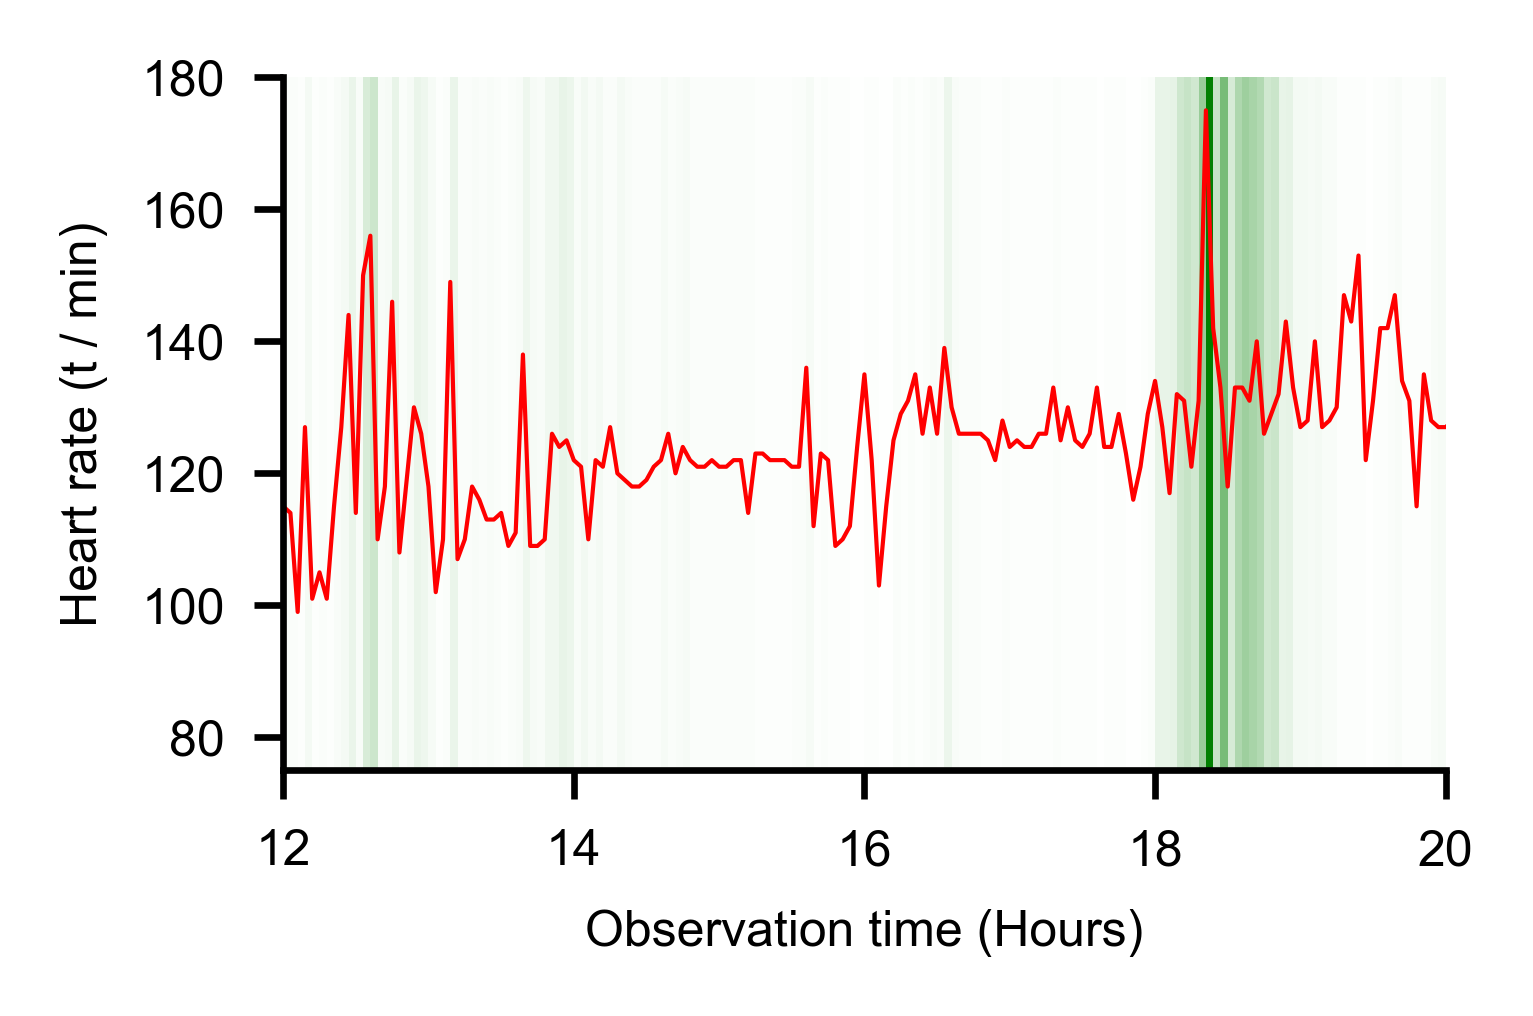

In [184]:
plt_fig, plt_axis=plt.subplots(1, figsize=(2.5,1.5))

x_values = np.arange(timeseries_length)

x_values = x_values / 20

half_col_width = (x_values[1] - x_values[0]) / 2.0

for icol, col_center in enumerate(x_values):
    left = col_center
    right = col_center + 2 * half_col_width
    plt_axis.axvspan(
        xmin=left,
        xmax=right,
        facecolor=(cmap(cm_norm(norm_attr[-1][icol]))),
        edgecolor=None,
        alpha=1,
    )


plt_axis.plot(x_values, data[-1,:], linewidth=0.5, c="r")

plt_axis.set_xlim(12,20)

plt_axis.set_ylim(75,180)

plt_axis.set_ylabel("Heart rate (t / min)")

plt_axis.set_xlabel("Observation time (Hours)")

plt_axis.spines['top'].set_visible(False)

plt_axis.spines['right'].set_visible(False)


plt.savefig('../draw/fig5_case_vital.svg', format='svg', dpi=600)